In [1]:
import copy
import numpy as np
import sys
import py2tex.py2tex as py2tex
import verdict
import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors

In [3]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [4]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [5]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [6]:
sim_name = 'm12i'
snum = 465

In [7]:
galdef = ''

In [8]:
file_manager = file_management.FileManager( 'hot_halo_physics' )

In [9]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_CGM_snum{}'.format( snum ),
    sim_name = sim_name,
    galdef = galdef
)

In [10]:
ind = defaults['ahf_index'] - snum

In [11]:
w = a_worldlines.Worldlines( **defaults )

In [12]:
w.retrieve_halo_data()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [13]:
print( w.tag )

m12i_CGM_snum465


In [14]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.25


In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [16]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

# Calculate $\theta$
Also called $\phi$...

In [17]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'ang_momentums_snum{}.hdf5'.format( snum ),
)

In [18]:
tot_momentums, attributes = verdict.Dict.from_hdf5( savefile, )

redshift = attributes['redshift']

In [19]:
w.calc_abs_phi( normal_vector=tot_momentums[sim_name] )

# Hot Mode Accretion Investigation

## Filter Data

### Select only the inner halo

In [20]:
w.data_masker.clear_masks( True )

In [21]:
w.data_masker.mask_data( 'PType', data_value=0 )

In [22]:
min_r_rvirs = {
    465: 0.2,
    172: 0.4,
}
max_r_rvirs = {
    465: 0.3,
    172: 0.5,
}

min_r_rvir = min_r_rvirs[snum]
max_r_rvir = max_r_rvirs[snum]

In [23]:
r_rvir = w.get_processed_data(
    'R',
    scale_key = 'Rvir',
    scale_a_power = 1.,
    scale_h_power = -1.,
)
in_region_at_ind = np.logical_and( ( min_r_rvir < r_rvir[:,ind] ), ( r_rvir[:,ind] < max_r_rvir ) )

in_region_at_ind_tiled = np.tile( in_region_at_ind, ( w.n_snaps, 1 ) ).transpose()
w.data_masker.mask_data( 'in_region', custom_mask=np.invert( in_region_at_ind_tiled ) )

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


### Select only a subset of time

In [24]:
t = w.get_data( 'time' )

In [25]:
x_min = t[ind]
x_maxes = {
    465: 12.5,
    172: 5,
}
x_max = x_maxes[snum]
x_range = [ x_min, x_max ]

In [26]:
w.data_masker.mask_data( 'time', x_min, x_max, tile_data=True )

In [27]:
n_snaps = ( ( t > x_min ) & ( t < x_max ) ).sum()

## Distribution Plots

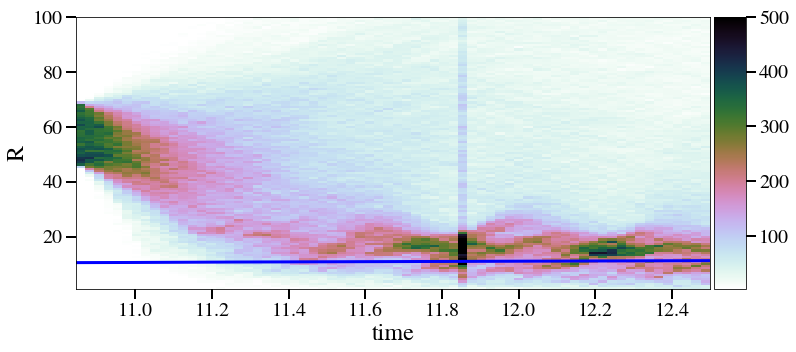

In [28]:
%matplotlib inline

fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'R',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
    cmap = cm.cubehelix_r,
#     y_scale = 'log',
    y_range = [ 1., 100. ],
    x_range = x_range,
    n_bins_x = n_snaps + 1,
    n_bins_y = 124,
)

ax.plot(
    w.get_data( 'time' )[:w.r_gal.size],
    w.r_gal,
    color = 'blue',
    linewidth = 3,
)

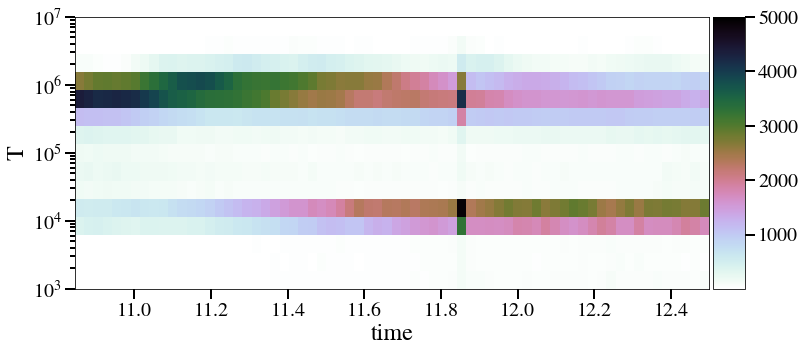

In [29]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'T',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=5000 ),
    y_scale = 'log',
    cmap = cm.cubehelix_r,
    y_range = [ 1e3, 1e7 ],
    x_range = x_range,
    n_bins_x = n_snaps + 1,
    n_bins = 16,
)

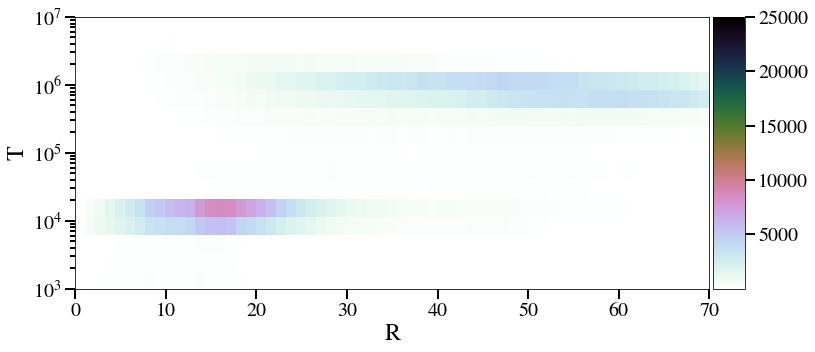

In [30]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'T',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=25000 ),
    y_scale = 'log',
    cmap = cm.cubehelix_r,
    x_range = [ 0, 70 ],
    y_range = [ 1e3, 1e7 ],
#     x_range = x_range,
    n_bins_x = 64,
    n_bins = 16,
)

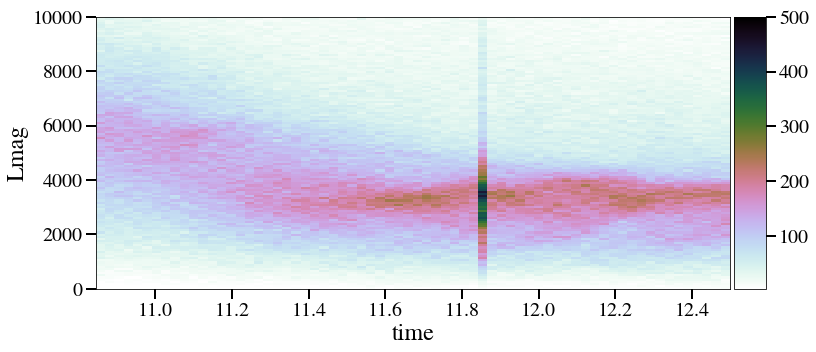

In [31]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'time',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = x_range,
    n_bins_x = n_snaps + 1,
    cmap = cm.cubehelix_r,
)

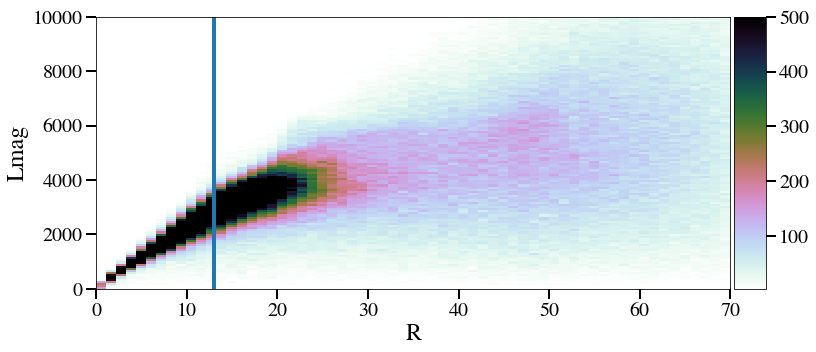

In [32]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'R',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

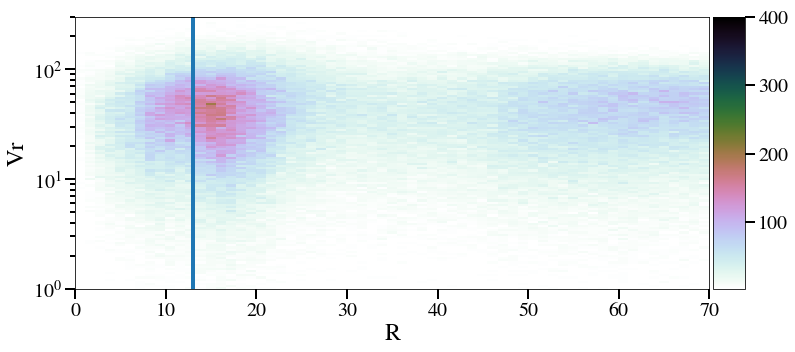

In [33]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Vr',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
    y_scale = 'log',
    y_range = [ 1., 300 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

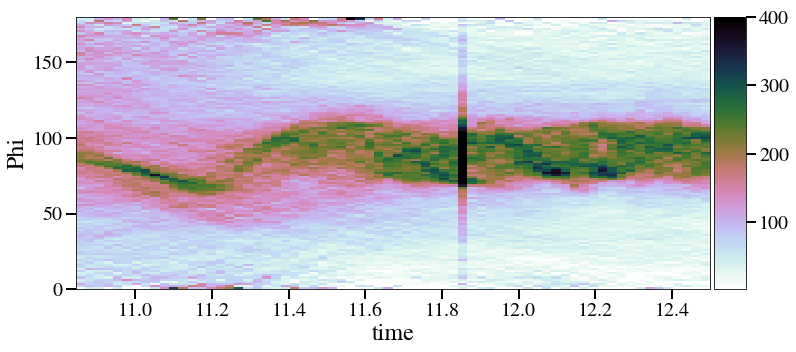

In [34]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = x_range,
    n_bins_x = n_snaps + 1,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

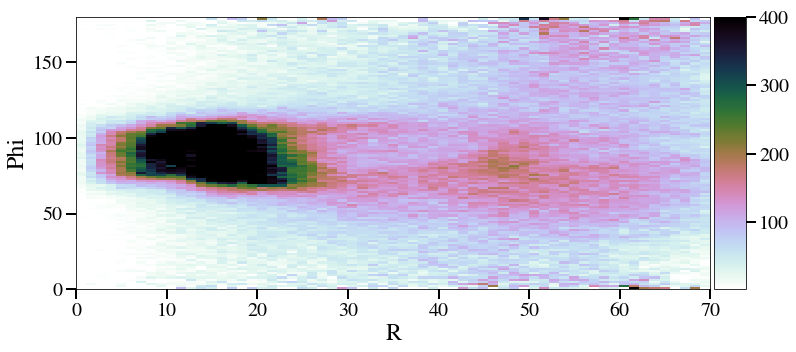

In [35]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

## Change the Masks into a Classification
For streamlines plots

In [36]:
is_selected = np.logical_and(
    np.invert( w.data_masker.masks[0]['mask'] ),
    np.invert( w.data_masker.masks[1]['mask'] ),
)

In [37]:
# In addition, we want to select particles that are never stars, because I think those are messing with our temperature plots.
is_always_gas = w.get_data( 'PType', sl=(slice(None),0) ) == 0
is_always_gas_tiled = np.tile( is_always_gas, (w.n_snaps, 1) ).transpose()
is_selected = np.logical_and( is_selected, is_always_gas_tiled )

In [38]:
w.data['is_selected'] = is_selected

In [39]:
# Let's also make sure we're only selecting gas that accretes
w.data['is_selected_acc'] = np.logical_and(
    w.get_data( 'is_CGM_accreted' ),
    is_selected,
)

#### Let's try selecting only particles that are within a distance r_in by t_later

In [40]:
t_later = 1.
r_in = 30.

In [41]:
# Find the time
time = w.get_data( 'time' )
later_time_inds = np.arange(time.size)[np.isclose( time[ind] + t_later, time, atol=0.01 )]
assert later_time_inds.size == 1
later_time_ind = later_time_inds[0]

In [42]:
r_later = w.get_data( 'R', sl=(slice(None),later_time_ind) )
is_within = r_later < r_in
is_within_tiled = np.tile( is_within, (w.n_snaps, 1) ).transpose()

In [43]:
# Let's also make sure we're only selecting gas that accretes
w.data['is_selected_acc_soon'] = np.logical_and(
    is_within_tiled,
    is_selected,
)

In [44]:
w.data_masker.clear_masks()

## Pathline Plots

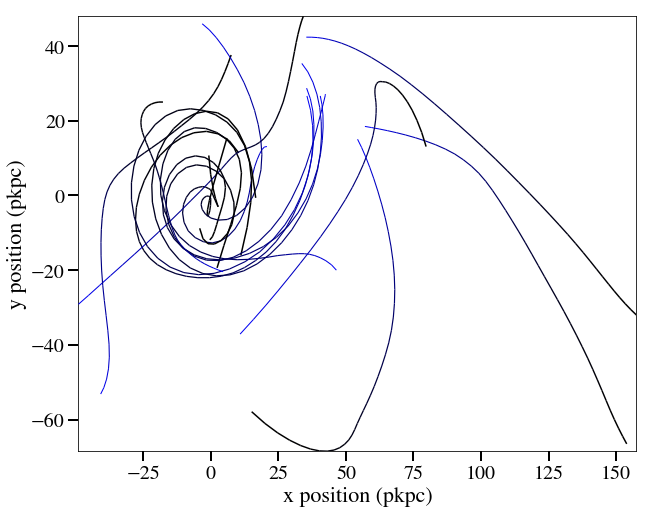

In [53]:
w_plotter.plot_streamlines(
    classification = 'is_selected',
    classification_ind = ind,
    start_ind = 'time_based',
    t_start = 1.,
    end_ind = ind,
    sample_size = 15,
    sample_selected_interval = False,
    x_data_kwargs = { 'tile_data': True, 'smooth_data' : True, 'smoothing_window_length' : 21 },
    y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 1,
)

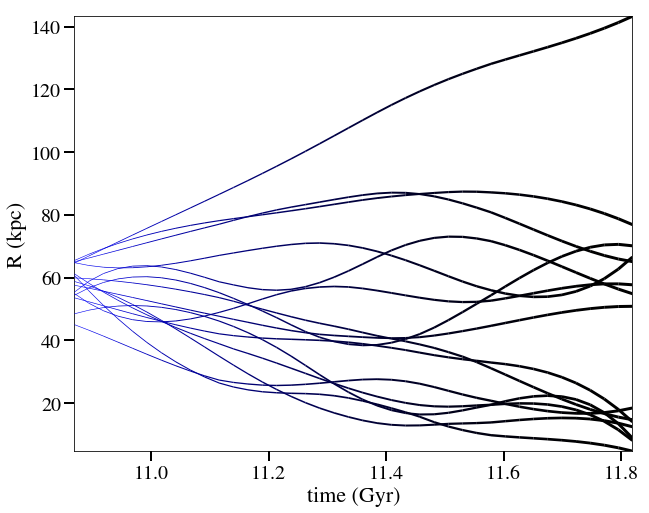

In [52]:
w_plotter.plot_streamlines(
    x_key = 'time',
    y_key = 'R',
    classification = 'is_selected',
    classification_ind = ind,
    start_ind = 'time_based',
    t_start = 1.,
    end_ind = ind,
    sample_size = 15,
    sample_selected_interval = False,
    x_data_kwargs = {
        'tile_data': True,
        'smooth_data' : True,
        'smoothing_window_length' : 21,
    },
    y_data_kwargs = {
        'smooth_data' : True,
        'smoothing_window_length' : 21,
    },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 0.5,
    linewidth = 3,
    x_label = 'time (Gyr)',
    y_label = 'R (kpc)',
)

In [47]:
gas_to_star_line_features = {
    'is_star': {
        'key': 'PType',
        'value': 4,
        'data_kwargs': {},
        'line_attrs': {
            'linewidth': 3,
            'color': 'k',
            },
    },
    'is_gas': {
        'key': 'PType',
        'value': 0,
        'data_kwargs': {},
        'line_attrs': {
            'linewidth': 2,
            'color': 'k',
            'linestyle': '--',
            },
        }
}

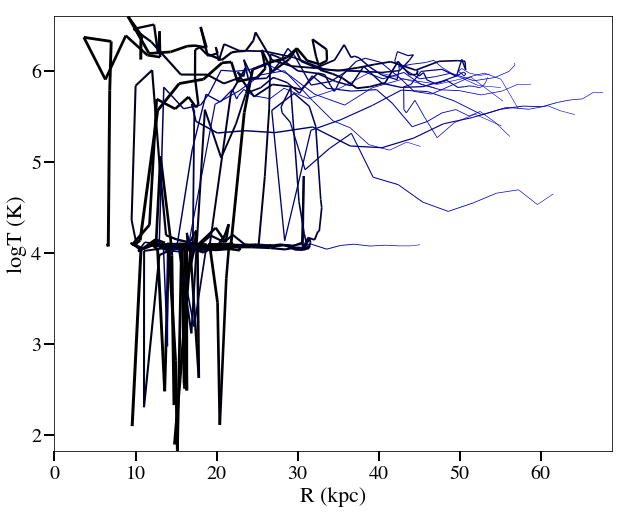

In [48]:
np.random.seed( 6 )

w_plotter.plot_streamlines(
    x_key = 'R',
    y_key = 'logT',
    classification = 'is_selected_acc_soon',
    classification_ind = ind,
#     sample_inds = selected_inds,
    start_ind = 'time_based',
    t_start = 1.,
    end_ind = ind,
    sample_size = 15,
    sample_selected_interval = False,
#     x_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 5 },
#     y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 5 },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 0.5,
#     fade_streamlines = False,
#     line_features = gas_to_star_line_features,
    linewidth = 3,
    x_label = 'R (kpc)',
    y_label = 'logT (K)',
#     y_scale = 'log',
    x_range = [ 0, w.r_vir[snum]*0.3 ],
#     y_range = [ 1e1, 1e7 ],
#     y_floor = 10.**3.8,
)

In [58]:
phi = w.get_selected_data(
    'Phi',
    classification = 'is_selected_acc_soon',
    sl = (slice(None),ind),
    compress = False,
)

In [61]:
phi_bins = np.linspace( 0., 180, 51 )
selected_inds = []
for i, phi_left in enumerate( phi_bins ):
    
    try:
        phi_right = phi_bins[i+1]
    except IndexError:
        break
        
    # Find the boolean for selected particles within the phi bin
    valid_phi = ( phi_left < phi ) & ( phi < phi_right )
    valid_other_selections = np.invert(phi.mask)
    valid = valid_phi & valid_other_selections
    
    # Continue when there are no particles that can be sampled
    if valid.sum() == 0:
        continue
    
    # Find the indices for the valid particles
    valid_inds = np.arange(w.n_particles)[valid]
    
    # Choose one per bin to append
    selected_inds.append( np.random.choice( valid_inds ) )
    
selected_inds = np.array( selected_inds )

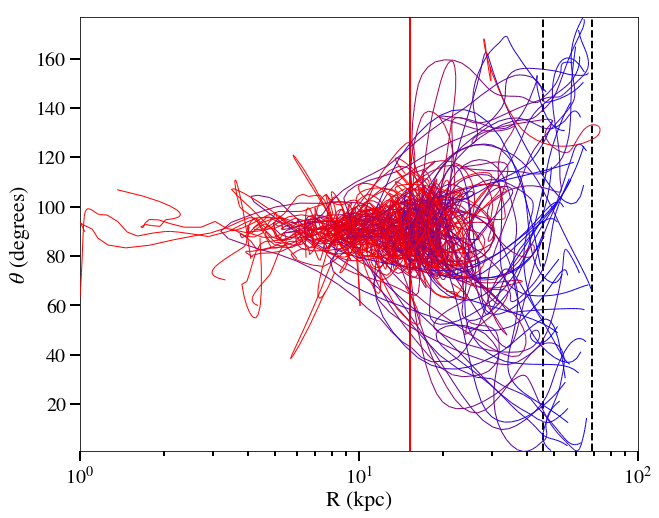

In [69]:
fig = plt.figure( figsize=(10,8), facecolor='white' )
ax = plt.gca()

w_plotter.plot_streamlines(
    ax = ax,
    x_key = 'R',
    y_key = 'Phi',
#     classification = 'is_selected',
#     classification_ind = ind,
    sample_inds = selected_inds,
    start_ind = 'time_based',
    t_start = 1.,
    end_ind = ind,
#     sample_size = 50,
    sample_selected_interval = False,
    x_data_kwargs = { 'tile_data': True, 'smooth_data' : True, 'smoothing_window_length' : 21 },
    y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    color = 'red',
    fade_color = 'blue',
    min_fade_linewidth = 1,
    linewidth = 1,
    x_label = 'R (kpc)',
    y_label = r'$\theta$ (degrees)',
    x_range = [ 0, w.r_vir[snum]*max_r_rvir ],
#     y_range = [ 1e3, 1e7 ],
)

ax.set_xscale( 'log' )
ax.set_xlim( 1, 100 )

rvir_snum = w.r_vir[snum]
ax.axvline(
    w.r_vir[snum] * min_r_rvir,
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)
ax.axvline(
    w.r_vir[snum] * max_r_rvir,
    color = 'k',
    linestyle = '--',
    linewidth = 2,
)

ax.axvline(
    w.r_gal[snum],
    color = 'red',
    linestyle = '-',
    linewidth = 2,
)

* Change $\theta$ to radians.
* Change line colors to blue to red with temperature color.
* Add transparency to the lines.
* Once accreted, stop plotting it.
* Make sure this is a snapshot with no outflow bursts.